# Economics Assignment (Guest Lecture) Part 2

#### Team: Mathieu Breier, Mikel Gallo, Luke Atazona

In [197]:
# Importing packages
import  os
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import sem
import datetime
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
# Measure multicolinearity
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [198]:
path = os.getcwd()

In [199]:
path+'/upccer.csv'

'/Users/mikelgallo/repos/Econm_HW5/upccer.csv'

### Load and Merge Data

In [200]:
# upload descriptive data
ds = pd.read_csv(path+'/upccer.csv',encoding='ISO-8859-1')

In [201]:
df = pd.read_csv(path+'/wcer.csv')

In [202]:
# Merge both upccer and wcer datasets
merged_df = df.merge(ds, on='UPC', how='left')

### Custom Functions

In [203]:
# Function for calculating frequency table
def freq_table(df,group_col,id_col):
    qty = pd.DataFrame(df.groupby(group_col,dropna=False)[id_col].count()).reset_index()
    qty['total'] = qty[id_col].sum()
    qty['perc']= round(qty[id_col] / qty['total'],4)
    qty['accum'] = round(qty['perc'].expanding().sum(),3) #Calculating running sum

    return qty
    

In [204]:
# Function for calculating conditional expectation function table
def CEF_table(df,group_col,id_col):
    qty = pd.DataFrame(df.groupby(group_col,dropna=False)[id_col].mean()).reset_index()
    return qty


In [205]:
#Function for calculating Summary statistics & Create a Dictionary for easy access

def numeric_cols(dataset):
    numerics = dataset.select_dtypes(include= np.number).columns.tolist()
    return numerics


def df_statistics(df):
    statistics = {}
    for i in df.columns:
        n = np.size(df[i])
        unique_vals = len(df[i].unique())
        mean = np.mean(df[i])
        per_25 = np.quantile(df[i],0.25)
        per_50 = np.quantile(df[i],0.50)
        per_75 = np.quantile(df[i],0.75)
        IQR = per_75 - per_25
        lower_b = per_25 - 1.5*IQR
        upper_b = per_75 + 1.5*IQR
        minimum = np.min(df[i])
        maximum = np.max(df[i])
        statistics[i] = [n,mean,per_25,per_50,per_75,IQR,lower_b,upper_b,minimum,maximum]
    # Transform dictionary into a Dataframe
    result = pd.DataFrame.from_dict(statistics,orient='index',columns=['n','mean','per_25','per_50','per_75','IQR','lower_b','upper_b','minimum','maximum'])
    result = result.round(2)
    result['lower_b'] = np.where((result['lower_b']<0) & (result['minimum']>=0),0,result['lower_b'])
    # Transform back to a dictionary
    result = result.to_dict('index')
    return result
    

### Feature description
  
###### Numericals:  
- Price: Represents the price of the UPC
- QTY: determines the size of the bundle but not the total number of units sold
- Move: determines the number of units sold
- Profit: indicates the gross margin in percent that DFF makes on the sale of the UPC (e.g.  DFF makes 25.3 cents on the dollar for each item sold)
  
###### Categoricals:
- Store: Indicates the identification number of each store.
- Sale:  indicates whether the product was sold on a promotion that week. A code of 'B' indicates a Bonus Buy, 'C' indicates a Coupon, 'S' indicate a simple price reduction.(DFF is not consistent setting this variable, which is why we will need to verify whether there was or not, an active promotion during the analyzed weeks.

###### Dates:
- week

###### Transformations:
- week_num [done]
- month_num [done]
- item_supplier: last digit of item_code (week supplier was manufacturer or DFF warehouse) [done]
- n_sale: indicates if promo/price reduction was active during the week (1=promo, 0= Nopromo)

###### Other:
- Remove rows with OK = 0

# Model Design (Cereals)

Units Sold = Price + distance_city_center + Festivity + month_number + Promotion

Target variable: Unit Solds

Endogenous variable: Price, distance_city_center, Promotion  
Exogenous variable: Festivity, month_number  

Objective is to maximize Units sold based on Price, Store location and Promotio(SALE) while controling for Festivities and month_number(Seasonality)

# Exloration Insights

#### Are promotions(Sales)/price reduction driving higher units sold?

- with the inclusion of featuring(Promotions), prices were notably lower for uncommon weeks (high volume of units sold). This indicates a strong connection between price reductions and an increase in the number of units sold. 

- On the other hand, when featuring present, there is an important tradeoff between lowering prices and profit. It would be good to value whether higher volume of units sold at a lower price compensates for the lower revenue margins.

#### Could seasonality be influencing units sold?  

 - Distribution of sales concentrate on the first and last months of the year.  
 - When looking at weeks with higher units solds, we can see that there's a higher avg of units solds in the months of April, September and November. Contrary, June proves to be the month with the lowest potential for higher sells.
 - We'll need to control for this exogenous variable in our models.

#### Could being closer to the city center increase the probability of selling more units of cereal?

 - Stores closer to the city center (e.g. case of store #75) show higher variability in the volume of units sold per week.
 - We should control for this endogenous variable (distance to city center)

### Transformations

##### Generate week_num, month_num and year columns

In [206]:
# Generate the date range
dates = pd.date_range(start='09/14/1989', end='05/07/1997', freq='6D')

# Function to calculate the week number within a month
def week_number_in_month(date):
    return (date.day - 1) // 7 + 1

# Calculate the week numbers and store them in a list
week_numbers = [week_number_in_month(date) for date in dates]


In [207]:
#Generate week number column
week_l = []
for i in range(1,467):
    week_l.append(i)
    i = i+1

In [208]:
date_table = pd.DataFrame({'WEEK' : week_l,
                                'DATES' : dates,
                                'WEEK_NUM' : week_numbers }, 
                                columns=['WEEK','DATES', 'WEEK_NUM'])

In [209]:
date_table['MONTH'] = date_table['DATES'].dt.month
date_table['YEAR'] = date_table['DATES'].dt.year

In [210]:
date_table.head()

,WEEK,DATES,WEEK_NUM,MONTH,YEAR
0,1,1989-09-14,2,9,1989
1,2,1989-09-20,3,9,1989
2,3,1989-09-26,4,9,1989
3,4,1989-10-02,1,10,1989
4,5,1989-10-08,2,10,1989


In [211]:
# Merge merged_df to date_table
dft = merged_df.merge(date_table, on='WEEK', how='left')

#### Create item_supplier column

In [212]:
dft['ITEM_SUPPLIER'] = dft['NITEM'].apply(lambda x: int(repr(x)[-1]))

##### Check for OK columns and remove any row that is not = 1

In [213]:
freq_table(dft,'OK','UPC')

,OK,UPC,total,perc,accum
0,0,141285,6602582,0.0214,0.021
1,1,6461297,6602582,0.9786,1.000


In [214]:
dft = dft[dft['OK'] == 1]

In [215]:
# fill NaN values in SALES with other value
dft['SALE'].fillna('None', inplace=True)

# Data Exploration

Explore main numeric variables to: understand distribution and associations with other variables.

In [216]:
# Create a dictionary with all statistics for numeric variables
numerics = numeric_cols(dft)
df_stats = df_statistics(dft[numerics])

#### Analyze Numerical variables MOVE, QTY, PRICE & PROFIT
- How are they distributed?
- Are there extreme values?

In [217]:
summary = pd.DataFrame(df_stats)
summary[['MOVE','QTY','PRICE','PROFIT']]

,MOVE,QTY,PRICE,PROFIT
n,6461297.00,6461297.0,6461297.00,6461297.00
mean,14.05,1.0,2.27,12.69
per_25,0.00,1.0,0.00,0.00
per_50,8.00,1.0,2.79,13.98
per_75,17.00,1.0,3.39,18.73
IQR,17.00,0.0,3.39,18.73
lower_b,0.00,1.0,0.00,-28.10
upper_b,42.50,1.0,8.48,46.82
minimum,0.00,1.0,0.00,-99.69
maximum,17824.00,4.0,26.02,99.99


## Analyzing QTY

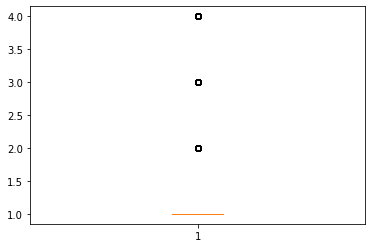

In [218]:
# QTY Distribution
plt.boxplot(dft['QTY'])
plt.show()

In [219]:
# QTY variable will indicate the size of the bundle (e.g 3 cans of tomatoes for $2)
freq_table(dft,'QTY','UPC')

,QTY,UPC,total,perc,accum
0,1,6456351,6461297,0.9992,0.999
1,2,3241,6461297,0.0005,1.000
2,3,568,6461297,0.0001,1.000
3,4,1137,6461297,0.0002,1.000


In the case of Cereals:
99% of weekly sales per upc are sold per unit. 
We can see that 1% of the times they are bundled for promotion purposes (bundle size can range btw 2 to 4 units)

QTY - determines the size of the bundle but not the number of units sold.

MOVE - Determines the number of units sold.

###### Conclusion: We don't care about this feature

## Analyzing MOVE (Target variable)

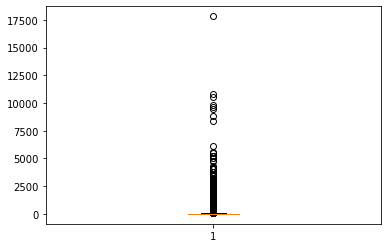

In [220]:
plt.boxplot(dft['MOVE'])
plt.show()

In [221]:
move_fr = freq_table(dft,'MOVE','UPC')

In [222]:
# What proportion of weekly sales had 0 units sold?
prop_0 = move_fr['accum'][move_fr['MOVE'] == 0].item()

print(f'Weeks with 0 units sold represent {prop_0} of all weekly units sold')

Weeks with 0 units sold represent 0.271 of all weekly units sold


In [223]:
#Which range of units sold do we consider to be a regular volume?
high = move_fr['MOVE'][(move_fr['MOVE'] < df_stats['MOVE']['upper_b'])].tail(1).item()
low = move_fr['MOVE'][(move_fr['MOVE'] > df_stats['MOVE']['lower_b'])].head(1).item()

print('###### COMMON WEEKS')
print(f'The range of units sold on common weeks is between {low} and {high}')

#What proportion of weekly sales does this range represent?
prop = move_fr['perc'][(move_fr['MOVE'] >= low) & (move_fr['MOVE'] <= high)].sum()

print(f'Common weeks represent {prop.round(2)} of all weekly units sold')

print(' ')
# What is the range of irregular weeks with extreme # units sold?
out_low = move_fr['MOVE'][(move_fr['MOVE'] > high)].head(1).item()
out_high = df_stats['MOVE']['maximum']

print('###### UNCOMMON WEEKS')
print(f'The range of units sold on uncommon weeks is between {out_low} and {out_high}')
print(f'Uncommon weeks represent {round(1 - prop_0 - prop,2)} of all weekly units sold')

print(' ')

print('###### NO SALES WEEKS')
print(f'Weeks with 0 units sold represent {prop_0} of all weekly units sold')

###### COMMON WEEKS
The range of units sold on common weeks is between 1 and 42
Common weeks represent 0.69 of all weekly units sold
 
###### UNCOMMON WEEKS
The range of units sold on uncommon weeks is between 43 and 17824.0
Uncommon weeks represent 0.04 of all weekly units sold
 
###### NO SALES WEEKS
Weeks with 0 units sold represent 0.271 of all weekly units sold


## Exploration Methodology

- We are going to split our Weeks/Observations based on the number of units sold (classification explained on previous step).

- ##### Goal: Find interesting patterns or associations that led to higher volumes of units sold

In [224]:
# Creating a common vs uncommon column
conditions = [
    (dft['MOVE'] >= low) & (dft['MOVE'] <= high),
    dft['MOVE'] == 0,
    dft['MOVE'] > high
]

choices = ['COMMON WEEKS', 'NO SALES', 'UNCOMMON WEEKS']

dft['Test'] = np.select(conditions, choices, default='OTHER')


In [225]:
# Creating a new Sales column with binary 1,0 (1 for promo/price reduction and 0 for None)
conditions = [
    dft['SALE'].isin(['B','G','S']),
    dft['SALE']=='None'
]

choices = [1, 0]

dft['n_sale'] = np.select(conditions, choices, default=1)

## Creating a Subset [efficiency purposes]

- Given the nature of the business (constantly changing prices and products) we need the most recent data, which is why we will foucs on the last 3 years of data (3 year to be able to look for seasonality patterns).

- In order to make our sample the most representative, we will pick a random number (30%) of stores and use them to subset our dataset.

In [226]:
# Randomize stores to better subset our dataset
subsample_size = int(0.30 * len(dft['STORE'].unique()))

# Randomly select a subsample from your data
subsampled_vals = dft['STORE'].sample(n=subsample_size, random_state=42) 

In [227]:
stores = subsampled_vals.tolist()

In [228]:
# Filter last 3 years /95/96/97
subset0 = dft[dft['WEEK']>= 278]

# Filter for only randomly selected stores
subset0 = subset0[subset0['STORE'].isin(stores)]

# New subset size
subset0.shape

(484757, 23)

In [229]:
subset0['STORE'].unique()

array([116,   5,   9,  12,  18,  40,  47,  48,  52,  54,  59,  62,  71,
        77,  78,  80,  86, 100, 112, 114, 115, 126, 128])

#### Create a new variable called city center, which marks 1 if the store is in the center and 0 otherwise

In [230]:
# Clustering Stores by distance from city center (Monocentric city model)
conditions = [
    subset0['STORE'].isin([9,12,62,86,128])
]

choices = [1]

subset0['city_center'] = np.select(conditions, choices, default=0)

In [231]:
# Clustering Stores by distance from city center (Monocentric city model)
conditions = [
    subset0['WEEK'].isin([180,185,194,199,208,216,220,224,225,232,238,246,251,260,268,272,276,277,284,289,
                         298,303,312,320,324,328,329,336,341,350,356,364,372,377,380,381,389,393]),
]

choices = [1]

subset0['festivity'] = np.select(conditions, choices, default=0)

## Are promotions the main reason behind higher units sold?

- Do price reductions/promos influence units sold? [YES] 

### Proportion of common weeks per SALE category

In [232]:
# Subset merged_df to only account for common range of units sold
common_df = subset0[subset0['Test'] == 'COMMON WEEKS']
#Create Frequency table to see the proportion of weeks with promotions 
table_1 = freq_table(common_df,'n_sale','MOVE')

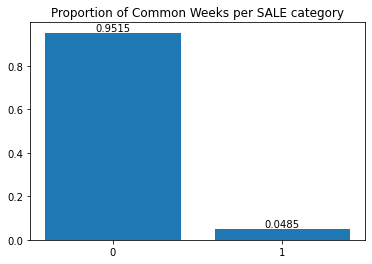

In [233]:
plt.bar(table_1['n_sale'].astype(str),table_1['perc'])
for i, v in enumerate(table_1['perc']):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.title('Proportion of Common Weeks per SALE category')
plt.show()

We can observe that the majority of common weeks, characterized by no extreme fluctuations in units sold, did not feature active promotions or price reductions. However, for weeks with active promotions or price reductions, further analysis is warranted. In the next section, we will compare these weeks to uncommon weeks to gain deeper insights.  

### Proportion of uncommon weeks per SALE category

In [234]:
# Subset merged_df to only account for common range of units sold
uncommon_df = subset0[subset0['Test'] == 'UNCOMMON WEEKS']
#Create Frequency table to see the proportion of weeks with promotions 
table_2 = freq_table(uncommon_df,'n_sale','MOVE')

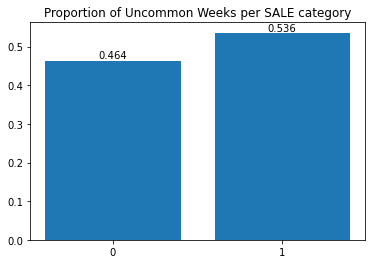

In [235]:
plt.bar(table_2['n_sale'].astype(str),table_2['perc'])
for i, v in enumerate(table_2['perc']):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.title('Proportion of Uncommon Weeks per SALE category')
plt.show()

Based on these results, we can anticipate that a minimum of 50% of the uncommon weeks, which are characterized by a high volume of units sold, may be influenced by promotions or price reductions.

What about the remaining half? What factors are driving the increase in units sold?

### Common vs Uncommon Analysis

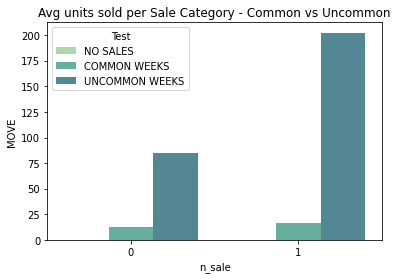

In [236]:
import cmocean
cpal = sns.color_palette("cmo.deep", n_colors=5)
sns.barplot(data=subset0, x="n_sale", y="MOVE", hue="Test", palette=cpal,ci=None)
plt.title('Avg units sold per Sale Category - Common vs Uncommon')
plt.show()


As previously highlighted, a marked contrast exists between the quantities of units sold in common and uncommon weeks. Delving deeper into the uncommon category, it is clear that being featured with a promotion substantially enhances unit sales.

However, a different scenario unfolds within the common category. Surprisingly, even with promotional features, there is minimal impact on the number of units sold during those weeks. While these cases represent a mere 5% of common weeks, we will investigate them to uncover any potential insights into the factors that might have influenced this phenomenon.

##### Validate if the magnitude of the price reduction could be a good explanatory variable for units sold.

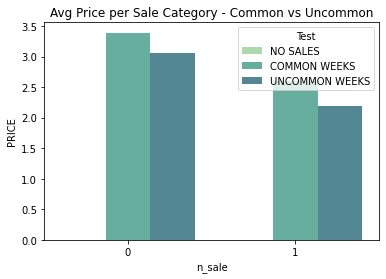

In [237]:
import cmocean
cpal = sns.color_palette("cmo.deep", n_colors=5)
sns.barplot(data=subset0, x="n_sale", y="PRICE", hue="Test", palette=cpal,ci=None)
plt.title('Avg Price per Sale Category - Common vs Uncommon')
plt.show()


In the first scenario, where featuring was absent, there was no significant difference in prices. This underscores the need for further investigation to elucidate the other factors that contributed to the upturn in unit sales during those uncommon weeks.

In the second scenario, with the inclusion of featuring, prices were notably lower for uncommon weeks. This indicates a strong connection between price reductions and an increase in the number of units sold.

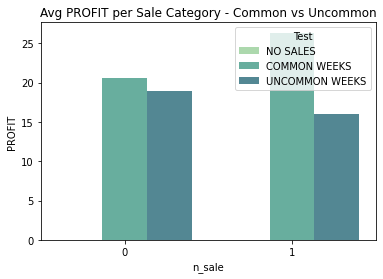

In [238]:
import cmocean
cpal = sns.color_palette("cmo.deep", n_colors=5)
sns.barplot(data=subset0, x="n_sale", y="PROFIT", hue="Test", palette=cpal,ci=None)
plt.title('Avg PROFIT per Sale Category - Common vs Uncommon')
plt.show()

Contrary to what we've seen in previous charts, When we look at the second scenario, Featuring present, there is an important tradeoff between lowering prices and profit.

It would be good to value whether higher volume of units sold at a lower price compensates for the lower revenue margins.

## Could seasonality be influencing the higher volumes of units sold?

- Seasonality influencing higher volumes? [Don't seem to be the case]

### Proportion of common weeks per Month

In [239]:
# Subset merged_df to only account for common range of units sold
common_df = subset0[subset0['Test'] == 'COMMON WEEKS']
#Create Frequency table to see the proportion of weeks with promotions 
table_1 = freq_table(common_df,'MONTH','MOVE')

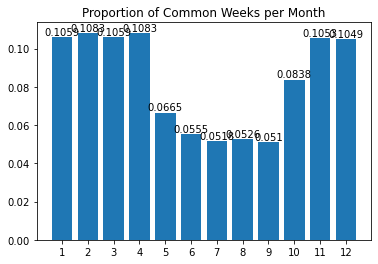

In [240]:
plt.bar(table_1['MONTH'].astype(str),table_1['perc'])
for i, v in enumerate(table_1['perc']):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.title('Proportion of Common Weeks per Month')
plt.show()

Distribution of common weeks concentrate on the first and last months of the year.

### Proportion of uncommon weeks per Month

In [241]:
# Subset merged_df to only account for common range of units sold
uncommon_df = subset0[subset0['Test'] == 'UNCOMMON WEEKS']
#Create Frequency table to see the proportion of weeks with promotions 
table_2 = freq_table(uncommon_df,'MONTH','MOVE')

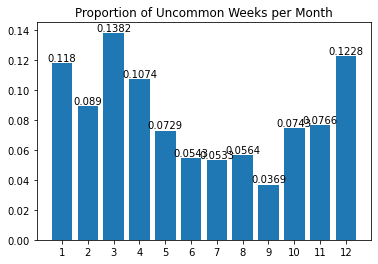

In [242]:
plt.bar(table_2['MONTH'].astype(str),table_2['perc'])
for i, v in enumerate(table_2['perc']):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.title('Proportion of Uncommon Weeks per Month')
plt.show()

Very similar behavior compared to common weeks.

### Common vs Uncommon Analysis

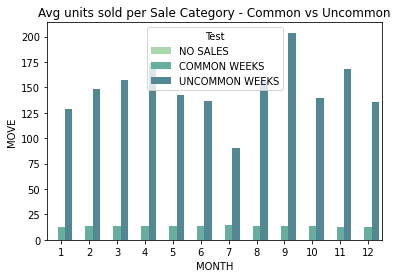

In [243]:
import cmocean
cpal = sns.color_palette("cmo.deep", n_colors=5)
sns.barplot(data=subset0, x="MONTH", y="MOVE", hue="Test", palette=cpal,ci=None)
plt.title('Avg units sold per Sale Category - Common vs Uncommon')
plt.show()

- When looking at weeks with higher units solds, we can see that there's a higher avg of units solds in the months of April, September and November. Contrary, June proves to be the month with the lowest potential for higher sells.

##### Validate if the magnitude of the price reduction could be a good explanatory variable for units sold.

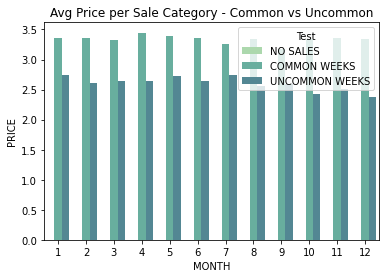

In [244]:
import cmocean
cpal = sns.color_palette("cmo.deep", n_colors=5)
sns.barplot(data=subset0, x="MONTH", y="PRICE", hue="Test", palette=cpal,ci=None)
plt.title('Avg Price per Sale Category - Common vs Uncommon')
plt.show()

- No major changes in avg prices per month

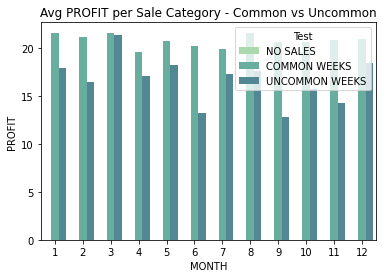

In [245]:
import cmocean
cpal = sns.color_palette("cmo.deep", n_colors=5)
sns.barplot(data=subset0, x="MONTH", y="PROFIT", hue="Test", palette=cpal,ci=None)
plt.title('Avg PROFIT per Sale Category - Common vs Uncommon')
plt.show()

- No large differences in avg profits per month

### Let's take a look at a Weekly level try to find some important events

Text(0.5, 1.0, 'AVG MOVE by WEEK_NUM over time')

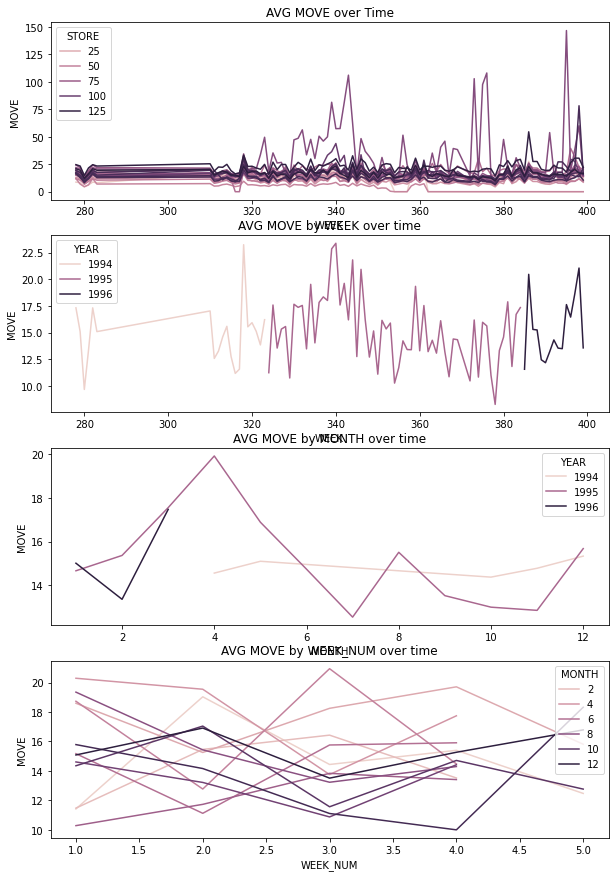

In [246]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))

# First subplot
sns.lineplot(data=subset0, x="WEEK", y="MOVE",hue="STORE", ax=ax[0], ci=None)  # ci=None to remove error bars
ax[0].set_title("AVG MOVE over Time")

# Second subplot
sns.lineplot(data=subset0, x="WEEK", y="MOVE", hue="YEAR", ax=ax[1], ci=None)  # ci=None to remove error bars
ax[1].set_title("AVG MOVE by WEEK over time")

# Third subplot
sns.lineplot(data=subset0, x="MONTH", y="MOVE", hue="YEAR", ax=ax[2], ci=None)  # ci=None to remove error bars
ax[2].set_title("AVG MOVE by MONTH over time")

#forth subplot
sns.lineplot(data=subset0, x="WEEK_NUM", y="MOVE", hue="MONTH", ax=ax[3], ci=None)  # ci=None to remove error bars
ax[3].set_title("AVG MOVE by WEEK_NUM over time")

#plt.show()

 - Stores closer to the city center (case of store #75) show higher variability in the volume of units sold per week.
 - We should control for this endogenous variable (distance to city center)

## Could the distance of the store to city center be influencing the higher volumes of units sold?

- It seems that being closer to the city center increase the variability of units sold per week?  

### Proportion of common weeks per Store's distance to city center.

In [247]:
# Subset merged_df to only account for common range of units sold
common_df = subset0[subset0['Test'] == 'COMMON WEEKS']
#Create Frequency table to see the proportion of weeks with promotions 
table_1 = freq_table(common_df,'city_center','MOVE')

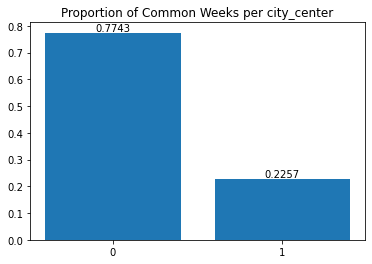

In [248]:
plt.bar(table_1['city_center'].astype(str),table_1['perc'])
for i, v in enumerate(table_1['perc']):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.title('Proportion of Common Weeks per city_center')
plt.show()

- Most stores are located further from city center

### Proportion of uncommon weeks per Store's distance to city center.

In [249]:
# Subset merged_df to only account for common range of units sold
uncommon_df = subset0[subset0['Test'] == 'UNCOMMON WEEKS']
#Create Frequency table to see the proportion of weeks with promotions 
table_2 = freq_table(uncommon_df,'city_center','MOVE')

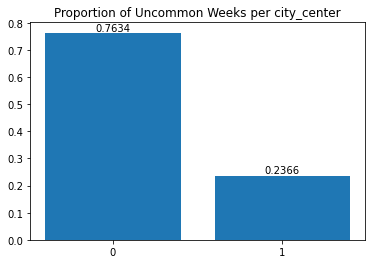

In [250]:
plt.bar(table_2['city_center'].astype(str),table_2['perc'])
for i, v in enumerate(table_2['perc']):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.title('Proportion of Uncommon Weeks per city_center')
plt.show()

- Most stores are located further from city center

### Common vs Uncommon Analysis

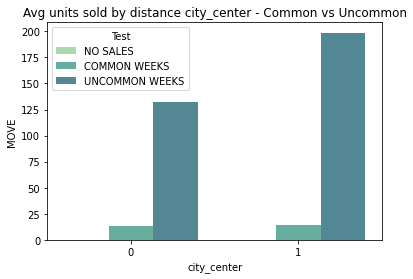

In [251]:
import cmocean
cpal = sns.color_palette("cmo.deep", n_colors=5)
sns.barplot(data=subset0, x="city_center", y="MOVE", hue="Test", palette=cpal,ci=None)
plt.title('Avg units sold by distance city_center - Common vs Uncommon')
plt.show()


- Seem to be higher probabilities of having weeks with larger volumes of units sold.

##### Validate if the magnitude of the price reduction could be a good explanatory variable for units sold.

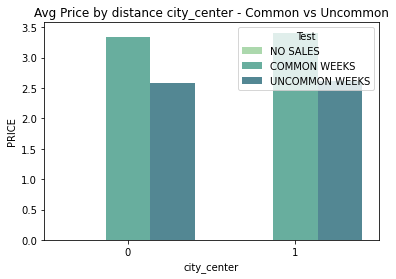

In [252]:
import cmocean
cpal = sns.color_palette("cmo.deep", n_colors=5)
sns.barplot(data=subset0, x="city_center", y="PRICE", hue="Test", palette=cpal,ci=None)
plt.title('Avg Price by distance city_center - Common vs Uncommon')
plt.show()


- No major differences in avg prices

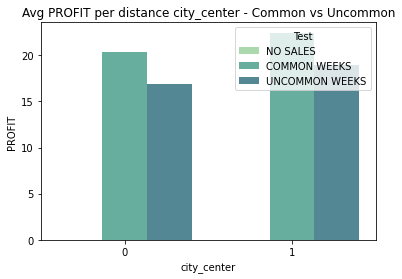

In [253]:
import cmocean
cpal = sns.color_palette("cmo.deep", n_colors=5)
sns.barplot(data=subset0, x="city_center", y="PROFIT", hue="Test", palette=cpal,ci=None)
plt.title('Avg PROFIT per distance city_center - Common vs Uncommon')
plt.show()

slightly higher profit if the store is located in the city center

### Outlier treatment

In [254]:
subset0.loc[subset0["MOVE"] > df_stats['MOVE']['upper_b'], "MOVE"] = df_stats['MOVE']['per_50']
subset0.loc[subset0["PRICE"] > df_stats['MOVE']['upper_b'], "PRICE"] = df_stats['PRICE']['per_50']

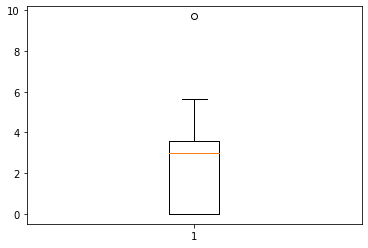

In [255]:
plt.boxplot(subset0["PRICE"])
plt.show()

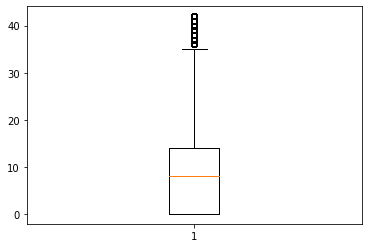

In [256]:
plt.boxplot(subset0["MOVE"])
plt.show()

### Feature Engineering

#### First we need to treat outliers in both Price and Move variables (Regression)

In [257]:
variables = ['UPC','MOVE','PRICE','PROFIT','WEEK_NUM','MONTH','YEAR','n_sale','city_center','festivity']

In [258]:
df = subset0[variables]
df

,UPC,MOVE,PRICE,PROFIT,WEEK_NUM,MONTH,YEAR,n_sale,city_center,festivity
172,317,0,0.00,0.00,3,8,1995,0,0,0
173,317,0,0.00,0.00,4,8,1995,0,0,0
174,317,0,0.00,0.00,1,9,1995,0,0,1
175,317,0,0.00,0.00,1,9,1995,0,0,0
176,317,0,0.00,0.00,2,9,1995,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6601595,79166919541,11,3.39,17.49,1,3,1996,0,1,0
6601596,79166919541,16,3.39,17.37,2,3,1996,0,1,0
6601597,79166919541,19,3.39,16.96,3,3,1996,0,1,0
6601598,79166919541,32,2.99,32.87,4,3,1996,1,1,0


In [259]:
# Apply one-hot encoding to distance from center
dummies = pd.get_dummies(df['WEEK_NUM'], prefix='w')
df= pd.concat([df, dummies], axis=1)

In [260]:
#Change dtypes for new dummy variables
#df['o_Area1'] = df['o_Area1'].astype(int)

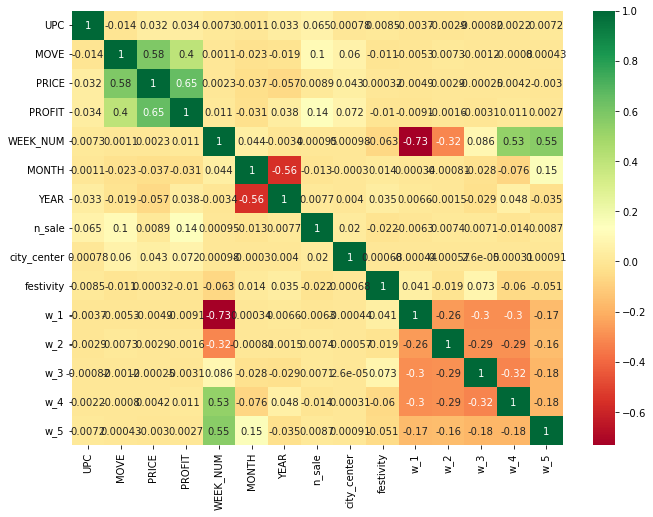

In [261]:
## Correlation Matrix
corr = df.corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap="RdYlGn", annot=True)
plt.show()

## Standarization

In [262]:
#Vars for Standarizing
vars = ['UPC','MOVE','PRICE','n_sale','city_center','festivity','w_1','w_2','w_3','w_4','w_5']

In [263]:
#  Standardize

def standarize_df(df,start_col):
    dz=df.copy()
    for i in df.iloc[:, start_col:].columns:
        if i not in ['UPC','MOVE','n_sale','city_center','festivity','w_1','w_2','w_3','w_4','w_5']:
            dz[i] = (df[i] - np.mean(df[i])) / np.std(df[i])
        else:
            dz[i] =  df[i]
    return dz


In [264]:
# New standarised dataframe
stz_df = standarize_df(df[vars],0)

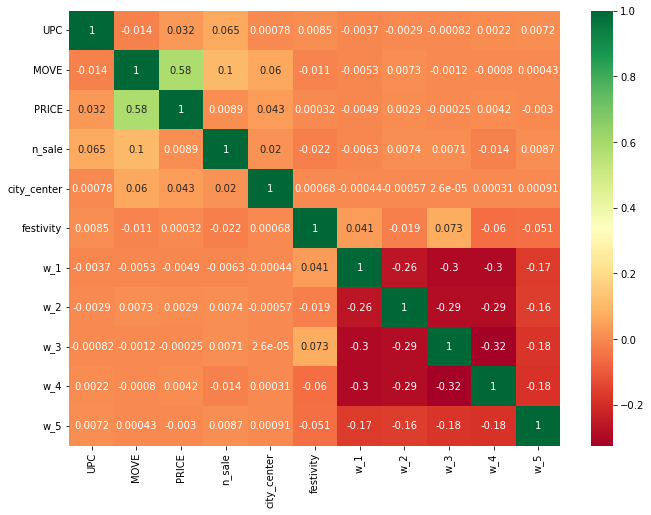

In [265]:
## Correlation Matrix
corr = stz_df[vars].corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap="RdYlGn", annot=True)
plt.show()

In [266]:
stz_df

,UPC,MOVE,PRICE,n_sale,city_center,festivity,w_1,w_2,w_3,w_4,w_5
172,317,0,-1.475713,0,0,0,0,0,1,0,0
173,317,0,-1.475713,0,0,0,0,0,0,1,0
174,317,0,-1.475713,0,0,1,1,0,0,0,0
175,317,0,-1.475713,0,0,0,1,0,0,0,0
176,317,0,-1.475713,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6601595,79166919541,11,0.631065,0,1,0,1,0,0,0,0
6601596,79166919541,16,0.631065,0,1,0,0,1,0,0,0
6601597,79166919541,19,0.631065,0,1,0,0,0,1,0,0
6601598,79166919541,32,0.382478,1,1,0,0,0,0,1,0


#### SPLIT DATA

In [267]:
# Function to split data
def splitdata(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [268]:
X_train, X_test, y_train, y_test  = splitdata(stz_df,'MOVE')

### Run Linear Regression

In [269]:
# Training Linear Model
X_train = X_train
X_test = X_test
y_train = y_train
y_test = y_test

# Train the model
model = LinearRegression()

model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Compute metrics
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("Regression Model")
#print("Train MSE:", train_mse)
print("Test MSE:", round(test_mse,2))
#print("Train R^2:", train_r2)
print("Test R^2:", round(test_r2,2))

# Print the coefficients and their corresponding feature names
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
print(round(coefficients,2))

Regression Model
Test MSE: 58.47
Test R^2: 0.35
       Feature  Coefficient
0          UPC        -0.00
1        PRICE         5.53
2       n_sale         4.04
3  city_center         0.78
4    festivity        -0.23
5          w_1        -0.04
6          w_2         0.09
7          w_3        -0.01
8          w_4        -0.04
9          w_5        -0.01


### RUN LASSO

We'll designate the alpha parameter as 1, governing the level of regularization in Lasso regression. Through the application of Lasso regression with this alpha value, we can explore its influence on both feature selection and regularization.

In [270]:
# Lasso Regression
alpha = 0.1  # Lower alpha value
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r_square = r2_score(y_test, lasso_pred)
print('Lasso Regression')
print("MSE Lasso:", round(lasso_mse,2))
print("R^2 Lasso:", round(lasso_r_square,2))

print("Lasso Coefficients:")
#for feature, coefficient in zip(X_train.columns, lasso.coef_):
    #print(feature, ":", round(coefficient,2))

coefficients_2 = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso.coef_})
print(round(coefficients_2,2))

Lasso Regression
MSE Lasso: 58.74
R^2 Lasso: 0.35
Lasso Coefficients:
       Feature  Coefficient
0          UPC        -0.00
1        PRICE         5.44
2       n_sale         2.15
3  city_center         0.22
4    festivity        -0.00
5          w_1        -0.00
6          w_2         0.00
7          w_3        -0.00
8          w_4        -0.00
9          w_5         0.00


### Run XGBoost (Blackbox)

In [271]:
# XGBoost Regression

# define model
model = XGBRegressor()

# fit model
model.fit(X_train, y_train)

# make a prediction
predictions = model.predict(X_test)

# summarize prediction
xgboost_mse = mean_squared_error(y_test, predictions)
xgboost_r_square = r2_score(y_test, predictions)

print('XGBoost Regression')
print("MSE XGBoost:", round(xgboost_mse,2))
print("R^2 XGBoost:", round(xgboost_r_square,2))


XGBoost Regression
MSE XGBoost: 39.0
R^2 XGBoost: 0.57


### Why can't we call the coefficients for XGBoost Regression?

In simple terms, coefficients are numbers that tell us how important each feature is when making predictions in a machine learning model. However, these coefficients are only meaningful when the model is set up as a linear model (like a straight line) and not when it's using other types of models (like tree-based models).

So, if you're using a linear model to make predictions, you can look at the coefficients to understand how much each feature matters. But if you're using a different type of model, like a tree-based model, you won't have these coefficients to interpret because the model works differently.

### However Both Accuracy and MSE are much better in the Black Box model